# Indigo Reviews AI: Data Preprocessing

This notebook handles data loading, preprocessing, and preparation for the Indigo Reviews AI project. It is responsible for:

1. Loading raw review data from various sources (CSV, API, mock data)
2. Cleaning and normalizing the text
3. Performing feature engineering (sentiment analysis, feature extraction)
4. Standardizing the data format for other notebooks
5. Exporting processed data for use in analysis, visualization, and dashboard notebooks

This modular approach improves performance and maintainability compared to the monolithic notebook.

## Navigation

In [10]:
# Navigation cell
from IPython.display import display, HTML

navbar = HTML("""
<div style="background-color: #444; padding: 10px; margin-bottom: 20px; border-radius: 5px;">
    <strong>App Reviews AI Notebooks:</strong>
    <a href="data_preprocessing.ipynb" target="_blank" style="margin-left: 15px; font-weight: bold;">Data Preprocessing</a>
    <a href="visualization_dashboard.ipynb" target="_blank" style="margin-left: 15px;">Visualizations</a>
    <a href="topic_analysis.ipynb" target="_blank" style="margin-left: 15px;">Topic Analysis</a>
    <a href="metrics_kpi.ipynb" target="_blank" style="margin-left: 15px;">Metrics & KPIs</a>
    <a href="llm_insights.ipynb" target="_blank" style="margin-left: 15px;">LLM Insights</a>
    <a href="dashboard_generator.ipynb" target="_blank" style="margin-left: 15px;">Dashboard Generator</a>
</div>
""")
display(navbar)

## Setup & Configuration

First, let's import the necessary libraries and set up our environment.

In [8]:
# Standard library imports
import os
import sys
import json
import warnings
from datetime import datetime
from typing import Dict, List, Any, Optional, Union

# Data analysis imports
import pandas as pd
import numpy as np

# Visualization imports for summary
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import ipywidgets as widgets

# Suppress warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Configure Matplotlib
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (12, 7)
%matplotlib inline

## Import Project Modules

Now we'll import our project's modules, with fallbacks in case they're not available.

In [9]:
# Try to import project modules with fallbacks
try:
    from src.modules.preprocessing.data_loader import load_reviews, preprocess_reviews, get_data_summary
    print("Successfully imported data loader module")
except ImportError as e:
    print(f"Error importing data loader: {e}")
    print("Creating fallback data loader functions...")
    
    # Define fallback functions
    def load_reviews(use_mock_data=True):
        """Fallback load_reviews function"""
        if use_mock_data:
            # Create a simple mock dataset
            print("Creating mock data")
            data = {
                'text': [
                    "Great app, love the booking experience!",
                    "App keeps crashing during payment",
                    "Decent app but needs improvement"
                ],
                'rating': [5, 1, 3],
                'date': [datetime.now(), datetime.now(), datetime.now()]
            }
            return pd.DataFrame(data)
        else:
            # Try to load from a CSV file
            print("Attempting to load reviews.csv")
            try:
                data_path = os.path.join(project_root, 'data', 'reviews.csv')
                return pd.read_csv(data_path)
            except Exception as e:
                print(f"Error loading CSV: {e}")
                print("Falling back to mock data")
                return load_reviews(use_mock_data=True)
    
    def preprocess_reviews(df):
        """Fallback preprocess_reviews function"""
        df = df.copy()
        
        # Basic text cleaning
        if 'text' in df.columns:
            df['cleaned_text'] = df['text'].apply(lambda x: str(x).lower() if pd.notna(x) else "")
            df['normalized_text'] = df['cleaned_text']
        
        return df
    
    def get_data_summary(df):
        """Fallback data summary function"""
        return {
            'total_reviews': len(df),
            'average_rating': df['rating'].mean() if 'rating' in df.columns else None
        }
    
    print("Fallback functions created.")

try:
    from src.modules.preprocessing.nlp_preprocessor import NLPPreprocessor
    print("Successfully imported NLP preprocessor")
except ImportError as e:
    print(f"Error importing NLP preprocessor: {e}")
    print("NLP functionality may be limited")

try:
    from src.config import config
    print("Successfully imported project config")
except ImportError as e:
    print(f"Error importing config: {e}")
    print("Using default configuration")
    config = {
        "data": {
            "default_source": "csv",
            "csv_path": os.path.join(project_root, 'data', 'reviews.csv'),
            "processed_path": os.path.join(project_root, 'data', 'processed_reviews.csv')
        }
    }

DEBUG: Applying APP_ID from environment: 'in.goindigo.android  # Google Play Store app ID'
Successfully imported data loader module
Successfully imported NLP preprocessor
Successfully imported project config


## Data Loading Options

This interactive section allows you to select the data source and load reviews accordingly.

In [12]:
# Create data loading widgets
data_source_widget = widgets.RadioButtons(
    options=['CSV File', 'API', 'Mock Data'],
    value='CSV File',
    description='Data Source:',
    disabled=False
)

csv_path_widget = widgets.Text(
    value=os.path.join(project_root, 'data', 'reviews.csv'),
    placeholder='Path to CSV file',
    description='CSV Path:',
    disabled=False
)

load_button = widgets.Button(
    description='Load Data',
    disabled=False,
    button_style='primary',
    tooltip='Click to load the data',
    icon='check'
)

output = widgets.Output()

def on_load_button_clicked(b):
    """Handle load button click"""
    global reviews_df  # Move global declaration to the beginning of the function
    
    output.clear_output()
    with output:
        # Determine data source
        source = data_source_widget.value
        print(f"Loading data from: {source}")
        
        if source == 'CSV File':
            # Get CSV path
            csv_path = csv_path_widget.value
            print(f"CSV Path: {csv_path}")
            
            # Check if file exists
            if not os.path.exists(csv_path):
                print(f"Warning: CSV file not found at {csv_path}")
                print("Checking default locations...")
                
                # Try default locations
                alt_paths = [
                    os.path.join(project_root, 'data', 'reviews.csv'),
                    os.path.join(os.getcwd(), 'data', 'reviews.csv')
                ]
                
                for alt_path in alt_paths:
                    if os.path.exists(alt_path):
                        print(f"Found CSV file at: {alt_path}")
                        csv_path = alt_path
                        break
                else:
                    print("No CSV file found. Falling back to mock data.")
                    reviews_df = load_reviews(use_mock_data=True)
                    display(reviews_df.head())
                    return
            
            # Load from CSV
            try:
                df = pd.read_csv(csv_path)
                
                # Convert date column if present
                date_columns = ['date', 'at', 'timestamp', 'created_at']
                for col in date_columns:
                    if col in df.columns:
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                        print(f"Converted '{col}' to datetime")
                        break
                
                reviews_df = df
                print(f"Successfully loaded {len(df)} reviews from CSV")
                display(df.head())
            except Exception as e:
                print(f"Error loading CSV: {e}")
                print("Falling back to mock data.")
                reviews_df = load_reviews(use_mock_data=True)
                display(reviews_df.head())
        
        elif source == 'API':
            print("API loading not implemented yet. Using mock data.")
            reviews_df = load_reviews(use_mock_data=True)
            display(reviews_df.head())
        
        else:  # Mock Data
            print("Generating mock review data...")
            reviews_df = load_reviews(use_mock_data=True)
            print(f"Generated {len(reviews_df)} mock reviews")
            display(reviews_df.head())

# Connect button to handler
load_button.on_click(on_load_button_clicked)

# Display widgets
display(widgets.VBox([
    widgets.HBox([data_source_widget]),
    widgets.HBox([csv_path_widget]),
    widgets.HBox([load_button]),
    output
]))

# Default data load
try:
    reviews_df = load_reviews(use_mock_data=False)
    with output:
        print(f"Auto-loaded {len(reviews_df)} reviews.")
        display(reviews_df.head())
except Exception as e:
    with output:
        print(f"Error during auto-load: {e}")
        print("Please use the Load Data button to load data.")

Loading preprocessed reviews from: /Users/dipesh/Local-Projects/indigo-reviews-ai/data/processed_reviews.csv
Successfully loaded 4398 preprocessed reviews


## Data Overview

Let's get a summary overview of the loaded data before preprocessing.

Total Reviews: 4398
Average Rating: 2.90 / 5.0

Column Information:


review_id                   object
author                      object
date                datetime64[ns]
rating                       int64
text                        object
version                     object
timestamp                  float64
thumbsUpCount                int64
replyContent                object
repliedAt                   object
cleaned_text                object
normalized_text             object
primary_topic              float64
topic_confidence           float64
dtype: object


Missing Values:


date                4398
version              610
timestamp           4398
replyContent        4369
repliedAt           4369
cleaned_text          30
normalized_text      116
primary_topic        116
topic_confidence     116
dtype: int64


Sample Data:


,review_id,author,date,rating,text,version,timestamp,thumbsUpCount,replyContent,repliedAt,cleaned_text,normalized_text,primary_topic,topic_confidence
887,2df04239-1ec5-48da-b9c0-b6417c341b7a,Rajendra Rao,NaT,2,Very frustrating to use this app. I am a regul...,7.0.9,NaN,7,NaN,NaN,very frustrating to use this app i am a regula...,frustrating use app regular user app last week...,4.0,0.585271
2475,f2c1900d-e5db-4682-9d3f-656c3ded4291,Suraj Anand,NaT,5,excellent,6.0.6,NaN,0,NaN,NaN,excellent,excellent,0.0,0.550000
2843,63b45daf-8612-4c27-8aee-ad912172c778,Dinesh Sirvi,NaT,5,good app,6.0.6,NaN,0,NaN,NaN,good app,good app,6.0,0.366667


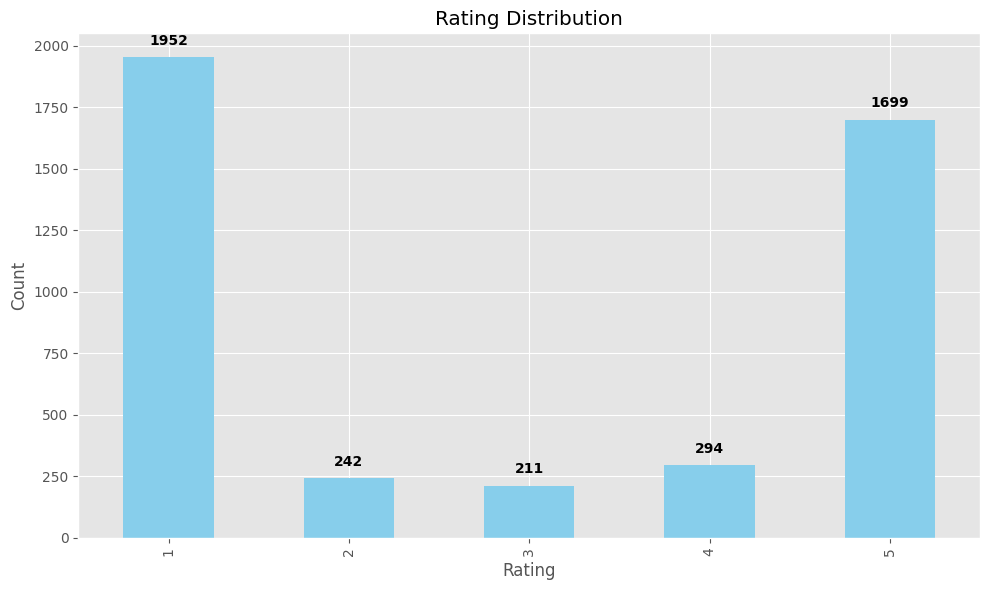

,Count,Percentage
rating,,
1,1952,44.4%
2,242,5.5%
3,211,4.8%
4,294,6.7%
5,1699,38.6%


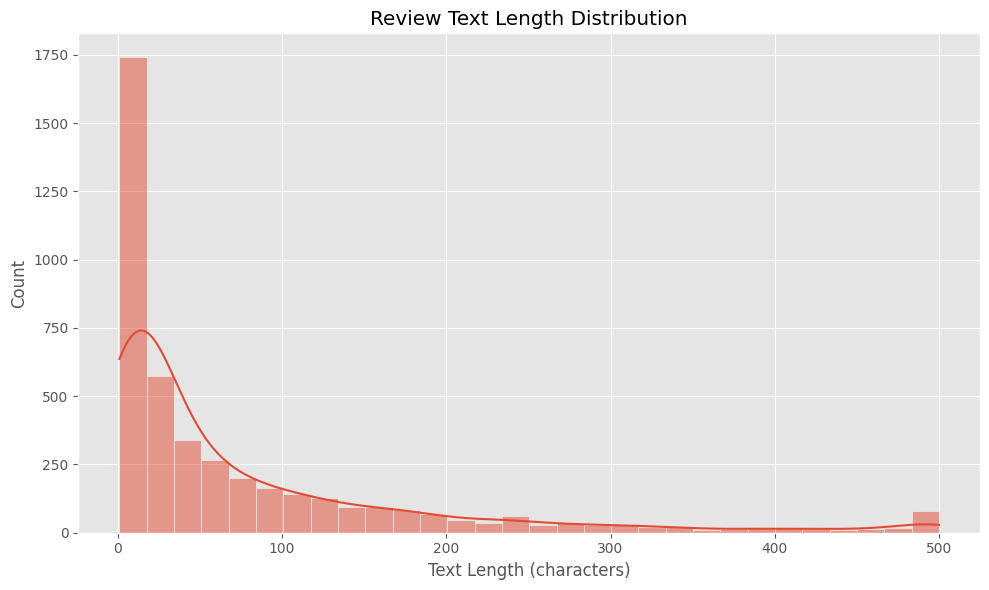


Text Length Statistics:


count    4398.0
mean       78.3
std       109.3
min         1.0
25%         9.0
50%        31.0
75%       101.8
max       500.0
Name: text_length, dtype: float64

Very short reviews (< 20 chars): 1818 (41.3%)
Empty reviews: 0 (0.0%)


In [13]:
def display_data_summary(df):
    """Display a comprehensive data summary"""
    # Get summary statistics
    summary = get_data_summary(df)
    
    # Display basic info
    print(f"Total Reviews: {summary['total_reviews']}")
    
    if 'average_rating' in summary and summary['average_rating'] is not None:
        print(f"Average Rating: {summary['average_rating']:.2f} / 5.0")
    
    if 'date_range' in summary and summary['date_range'] is not None:
        date_range = summary['date_range']
        print(f"Date Range: {date_range['start']} to {date_range['end']} ({date_range['days']} days)")
    
    # Display column information
    print("\nColumn Information:")
    display(df.dtypes)
    
    # Display missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        display(missing[missing > 0])
    else:
        print("\nNo missing values found.")
    
    # Display sample data
    print("\nSample Data:")
    display(df.sample(3))
    
    # Display rating distribution
    if 'rating' in df.columns:
        plt.figure(figsize=(10, 6))
        rating_counts = df['rating'].value_counts().sort_index()
        ax = rating_counts.plot(kind='bar', color='skyblue')
        plt.title('Rating Distribution')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        
        # Add count labels on top of bars
        for i, count in enumerate(rating_counts):
            ax.text(i, count + (rating_counts.max() * 0.02), 
                    str(count), 
                    ha='center', va='bottom',
                    fontweight='bold')
            
        plt.tight_layout()
        plt.show()
        
        # Percentage distribution
        rating_percentage = df['rating'].value_counts(normalize=True).sort_index() * 100
        rating_table = pd.DataFrame({
            'Count': rating_counts,
            'Percentage': rating_percentage.round(1).map(lambda x: f"{x:.1f}%")
        })
        display(rating_table)
    
    # Text length distribution if text column exists
    if 'text' in df.columns:
        df['text_length'] = df['text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
        
        plt.figure(figsize=(10, 6))
        sns.histplot(df['text_length'], bins=30, kde=True)
        plt.title('Review Text Length Distribution')
        plt.xlabel('Text Length (characters)')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        # Text length statistics
        text_stats = df['text_length'].describe().round(1)
        print("\nText Length Statistics:")
        display(text_stats)
        
        # Short reviews count
        short_reviews = (df['text_length'] < 20).sum()
        print(f"Very short reviews (< 20 chars): {short_reviews} ({short_reviews/len(df)*100:.1f}%)")
        
        # Empty reviews count
        empty_reviews = (df['text_length'] == 0).sum()
        print(f"Empty reviews: {empty_reviews} ({empty_reviews/len(df)*100:.1f}%)")

# Display summary of loaded data
try:
    display_data_summary(reviews_df)
except NameError:
    print("No data loaded yet. Please load data using the options above.")
except Exception as e:
    print(f"Error displaying summary: {e}")

## Data Preprocessing

Now we'll apply preprocessing to clean and normalize the text data, and prepare it for analysis.

In [14]:
# Preprocess the data
try:
    # Check if data is loaded
    if 'reviews_df' not in globals():
        print("No data loaded yet. Please load data using the options above.")
    else:
        print(f"Preprocessing {len(reviews_df)} reviews...")
        processed_df = preprocess_reviews(reviews_df)
        print("Preprocessing complete.")
        
        # Display sample of preprocessed data
        if 'cleaned_text' in processed_df.columns and 'normalized_text' in processed_df.columns:
            sample_cols = ['text', 'cleaned_text', 'normalized_text']
            if 'rating' in processed_df.columns:
                sample_cols = ['rating'] + sample_cols
            
            print("\nSample of preprocessed text:")
            display(processed_df[sample_cols].head(3))
            
            # Text cleaning impact
            original_chars = processed_df['text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0).sum()
            cleaned_chars = processed_df['cleaned_text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0).sum()
            normalized_chars = processed_df['normalized_text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0).sum()
            
            print(f"\nText cleaning impact:")
            print(f"Original text: {original_chars:,} total characters")
            print(f"Cleaned text: {cleaned_chars:,} total characters ({cleaned_chars/original_chars*100:.1f}% of original)")
            print(f"Normalized text: {normalized_chars:,} total characters ({normalized_chars/original_chars*100:.1f}% of original)")
        else:
            print("\nWarning: Expected preprocessing columns not found.")
            print("Available columns:")
            print(processed_df.columns.tolist())
except Exception as e:
    print(f"Error during preprocessing: {e}")

Preprocessing 4398 reviews...
Cleaning and normalizing review text...
Preprocessing complete.
Preprocessing complete.

Sample of preprocessed text:


,rating,text,cleaned_text,normalized_text
0,1,This app is too bad. To start with the perform...,this app is too bad to start with the performa...,app bad start performance slow end error somet...
1,2,glitches,glitches,glitch
2,1,What a waste of time.. most annoying app ever....,what a waste of time most annoying app ever ca...,waste time annoying app ever cant even edit na...



Text cleaning impact:
Original text: 344,492 total characters
Cleaned text: 331,925 total characters (96.4% of original)
Normalized text: 232,125 total characters (67.4% of original)


## Feature Engineering

Now let's add additional features that will be useful for analysis.

Starting feature engineering...
Calculating sentiment scores...
Sentiment analysis complete.
Extracting time features...
Time features extraction complete.
Feature engineering complete.

Sample of enhanced data:


,review_id,author,date,rating,text,version,timestamp,thumbsUpCount,replyContent,repliedAt,...,year,month,day,day_of_week,day_name,is_weekend,year_month,quarter,year_quarter,text_length_category
3404,9bee3555-f020-437c-9936-4cb92dd349dd,Anjan chakraborty,NaT,5,ok,6.0.5,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_short
3125,0e174556-c75c-4fd5-b9e6-96c2cc5ee714,varsha gupta,NaT,2,very slow response,6.0.6,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_short
1108,c6a51e8e-d42f-4f21-ae60-ee2d0438ada8,Anuj Sinha,NaT,1,"Pathetic, filled with bugs, very slow. Please ...",6.0.2,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,short



Sentiment statistics:


,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound
count,4398.000000,4398.000000,4398.000000,4398.000000
mean,0.105721,0.537978,0.355847,0.070143
std,0.188343,0.366964,0.408272,0.482795
min,0.000000,0.000000,0.000000,-0.973800
25%,0.000000,0.222000,0.000000,-0.340000
50%,0.000000,0.628500,0.116000,0.014900
75%,0.153000,0.856750,0.762000,0.440400
max,1.000000,1.000000,1.000000,0.981100


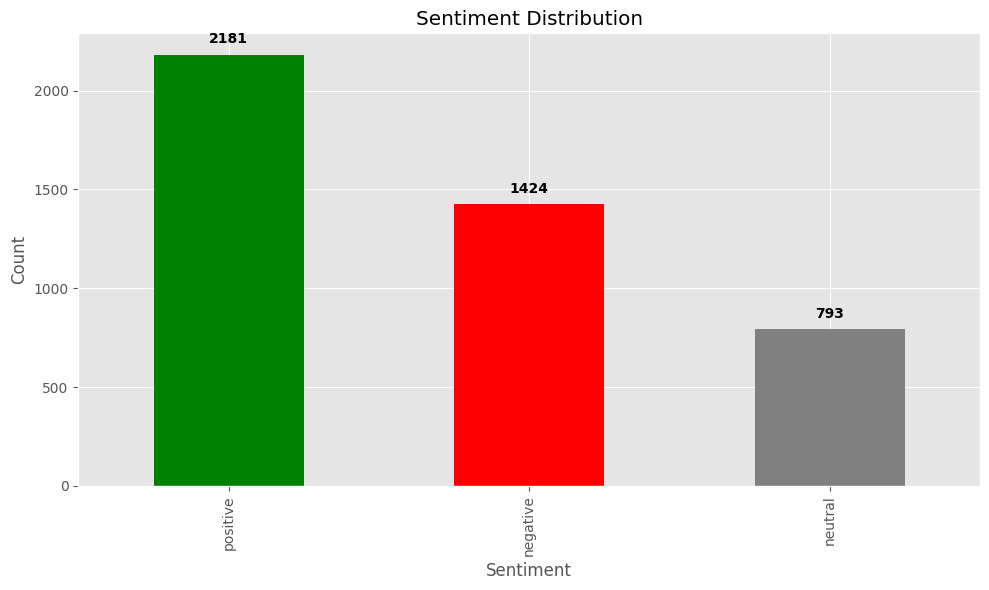

Saved enhanced data to: /Users/dipesh/Local-Projects/indigo-reviews-ai/data/processed/enhanced_reviews_20250508_104711.csv
Saved enhanced data to standard location: /Users/dipesh/Local-Projects/indigo-reviews-ai/data/enhanced_reviews.csv

Export Summary:
Total rows: 4398
Total columns: 30
Columns included:
  Original (15): review_id, author, date, rating, text, version, timestamp, thumbsUpCount, replyContent, repliedAt, cleaned_text, normalized_text, primary_topic, topic_confidence, text_length
  Processed Text (1): text_length_category
  Sentiment (5): sentiment_negative, sentiment_neutral, sentiment_positive, sentiment_compound, sentiment_category
  Time (8): year, month, day, day_of_week, is_weekend, year_month, quarter, year_quarter
  Other (1): day_name


In [15]:
# Feature engineering functions
def add_sentiment_score(df, text_column='cleaned_text'):
    """Add sentiment score using NLTK's VADER sentiment analyzer"""
    try:
        # Import NLTK's VADER sentiment analyzer
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        import nltk
        
        # Download VADER lexicon if not already downloaded
        try:
            nltk.data.find('sentiment/vader_lexicon.zip')
        except LookupError:
            nltk.download('vader_lexicon', quiet=True)
        
        # Initialize the sentiment analyzer
        sia = SentimentIntensityAnalyzer()
        
        # Create a copy of the dataframe
        result_df = df.copy()
        
        # Ensure text column exists
        if text_column not in result_df.columns:
            print(f"Warning: Column '{text_column}' not found. Using 'text' column.")
            text_column = 'text' if 'text' in result_df.columns else None
            
            if text_column is None:
                print("Error: No text column found for sentiment analysis.")
                return result_df
        
        # Apply sentiment analysis
        print("Calculating sentiment scores...")
        
        # Function to get sentiment scores
        def get_sentiment(text):
            if pd.isna(text) or text == "":
                return {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
            return sia.polarity_scores(text)
        
        # Apply sentiment analysis
        sentiments = result_df[text_column].apply(get_sentiment)
        
        # Extract sentiment components
        result_df['sentiment_negative'] = sentiments.apply(lambda x: x['neg'])
        result_df['sentiment_neutral'] = sentiments.apply(lambda x: x['neu'])
        result_df['sentiment_positive'] = sentiments.apply(lambda x: x['pos'])
        result_df['sentiment_compound'] = sentiments.apply(lambda x: x['compound'])
        
        # Add sentiment category
        def categorize_sentiment(compound):
            if compound >= 0.05:
                return 'positive'
            elif compound <= -0.05:
                return 'negative'
            else:
                return 'neutral'
        
        result_df['sentiment_category'] = result_df['sentiment_compound'].apply(categorize_sentiment)
        
        print("Sentiment analysis complete.")
        return result_df
    except Exception as e:
        print(f"Error during sentiment analysis: {e}")
        print("Skipping sentiment analysis.")
        return df

def add_time_features(df, date_column='date'):
    """Add time-based features extracted from the date column"""
    # Create a copy of the dataframe
    result_df = df.copy()
    
    # Ensure date column exists
    if date_column not in result_df.columns:
        print(f"Warning: Column '{date_column}' not found. Checking alternative date columns.")
        date_alternatives = ['at', 'timestamp', 'created_at']
        
        for alt in date_alternatives:
            if alt in result_df.columns:
                date_column = alt
                print(f"Using '{date_column}' as date column.")
                break
        else:
            print("Error: No date column found for time feature extraction.")
            return result_df
    
    # Ensure date column is datetime
    if not pd.api.types.is_datetime64_dtype(result_df[date_column]):
        print(f"Converting '{date_column}' to datetime...")
        result_df[date_column] = pd.to_datetime(result_df[date_column], errors='coerce')
    
    # Extract time features
    print("Extracting time features...")
    
    # Remove rows with NaT in date column
    valid_dates = result_df[date_column].notna()
    if valid_dates.sum() < len(result_df):
        print(f"Warning: {len(result_df) - valid_dates.sum()} rows have invalid dates and will have NaN time features.")
    
    # Apply extraction only to valid dates
    result_df['year'] = result_df.loc[valid_dates, date_column].dt.year
    result_df['month'] = result_df.loc[valid_dates, date_column].dt.month
    result_df['day'] = result_df.loc[valid_dates, date_column].dt.day
    result_df['day_of_week'] = result_df.loc[valid_dates, date_column].dt.dayofweek
    result_df['day_name'] = result_df.loc[valid_dates, date_column].dt.day_name()
    result_df['is_weekend'] = result_df.loc[valid_dates, 'day_of_week'].apply(lambda x: x >= 5)
    
    # Add year-month column for time series aggregation
    result_df['year_month'] = result_df.loc[valid_dates, date_column].dt.strftime('%Y-%m')
    
    # Add quarter
    result_df['quarter'] = result_df.loc[valid_dates, date_column].dt.quarter
    result_df['year_quarter'] = result_df.loc[valid_dates, 'year'].astype(str) + '-Q' + result_df.loc[valid_dates, 'quarter'].astype(str)
    
    print("Time features extraction complete.")
    return result_df

def engineer_features(df):
    """Apply all feature engineering steps"""
    print("Starting feature engineering...")
    
    # Make a copy of the dataframe
    result_df = df.copy()
    
    # Add sentiment scores
    if 'cleaned_text' in result_df.columns:
        result_df = add_sentiment_score(result_df, text_column='cleaned_text')
    else:
        result_df = add_sentiment_score(result_df)
    
    # Add time features
    date_column = None
    for col in ['date', 'at', 'timestamp', 'created_at']:
        if col in result_df.columns:
            date_column = col
            break
    
    if date_column is not None:
        result_df = add_time_features(result_df, date_column=date_column)
    
    # Add text length features
    if 'text' in result_df.columns:
        result_df['text_length'] = result_df['text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
        
        # Categorize by text length
        def categorize_length(length):
            if length == 0:
                return 'empty'
            elif length < 50:
                return 'very_short'
            elif length < 200:
                return 'short'
            elif length < 500:
                return 'medium'
            else:
                return 'long'
        
        result_df['text_length_category'] = result_df['text_length'].apply(categorize_length)
    
    print("Feature engineering complete.")
    return result_df

# Apply feature engineering
try:
    # Check if processed data is available
    if 'processed_df' not in globals():
        print("Processed data not available. Preprocessing first...")
        processed_df = preprocess_reviews(reviews_df)
    
    # Apply feature engineering
    enhanced_df = engineer_features(processed_df)
    
    # Display sample of enhanced data
    print("\nSample of enhanced data:")
    display(enhanced_df.sample(3))
    
    # Get numerical columns for quick stats
    numerical_cols = enhanced_df.select_dtypes(include=['number']).columns.tolist()
    sentiment_cols = [col for col in numerical_cols if 'sentiment' in col]
    
    if sentiment_cols:
        print("\nSentiment statistics:")
        display(enhanced_df[sentiment_cols].describe())
        
        # Display sentiment distribution
        sentiment_counts = enhanced_df['sentiment_category'].value_counts()
        plt.figure(figsize=(10, 6))
        colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
        ax = sentiment_counts.plot(kind='bar', color=[colors.get(x, 'blue') for x in sentiment_counts.index])
        plt.title('Sentiment Distribution')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        
        # Add count labels
        for i, count in enumerate(sentiment_counts):
            ax.text(i, count + (sentiment_counts.max() * 0.02), 
                    str(count), 
                    ha='center', va='bottom',
                    fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error during feature engineering: {e}")
    print("Traceback:")
    import traceback
    traceback.print_exc()

# Save the final output to a CSV for other notebooks
try:
    if 'enhanced_df' in globals():
        # Create output directory if it doesn't exist
        output_dir = os.path.join(project_root, 'data', 'processed')
        os.makedirs(output_dir, exist_ok=True)
        
        # Define output path with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_path = os.path.join(output_dir, f'enhanced_reviews_{timestamp}.csv')
        standard_path = os.path.join(project_root, 'data', 'enhanced_reviews.csv')
        
        # Save to timestamped file
        enhanced_df.to_csv(output_path, index=False)
        print(f"Saved enhanced data to: {output_path}")
        
        # Also save to standard location
        enhanced_df.to_csv(standard_path, index=False)
        print(f"Saved enhanced data to standard location: {standard_path}")
        
        # Display export information
        print("\nExport Summary:")
        print(f"Total rows: {len(enhanced_df)}")
        print(f"Total columns: {len(enhanced_df.columns)}")
        print("Columns included:")
        
        # Group columns by category
        column_categories = {
            'Original': [col for col in enhanced_df.columns if col in reviews_df.columns],
            'Processed Text': [col for col in enhanced_df.columns if 'text' in col and col not in reviews_df.columns],
            'Sentiment': [col for col in enhanced_df.columns if 'sentiment' in col],
            'Time': [col for col in enhanced_df.columns if col in ['year', 'month', 'day', 'quarter', 'day_of_week', 'is_weekend', 'year_month', 'year_quarter']],
            'Other': [col for col in enhanced_df.columns if not any(col in category for category in [
                [col for col in enhanced_df.columns if col in reviews_df.columns],
                [col for col in enhanced_df.columns if 'text' in col and col not in reviews_df.columns],
                [col for col in enhanced_df.columns if 'sentiment' in col],
                [col for col in enhanced_df.columns if col in ['year', 'month', 'day', 'quarter', 'day_of_week', 'is_weekend', 'year_month', 'year_quarter']]
            ])]
        }
        
        for category, cols in column_categories.items():
            if cols:
                print(f"  {category} ({len(cols)}): {', '.join(cols)}")
    else:
        print("No enhanced data available to save. Please run the feature engineering step first.")
except Exception as e:
    print(f"Error saving data: {e}")

## Conclusion

We've successfully loaded, preprocessed, and enhanced the review data. The key steps performed were:

1. Loading data from CSV (or generating mock data if needed)
2. Standardizing column names and formats
3. Cleaning and normalizing text data
4. Adding sentiment analysis features
5. Adding time-based features
6. Categorizing reviews by length and sentiment
7. Exporting the enhanced data for use in other notebooks

The processed data is now ready for use in the following notebooks:
- Visualization Dashboard
- Topic Analysis
- Metrics & KPIs
- LLM Insights

This modular approach allows for more efficient processing and better organization of the codebase.